In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

MUST RUN "pip install arch"

In [2]:
df = pd.read_csv('stock data.csv', sep=';', decimal=',',thousands='.')

In [3]:
#Transforming data

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)


In [4]:
returns = df.pct_change() #Calculating the daily return
print(returns)


                 c25     sp500       dax
Date                                    
2017-01-03       NaN       NaN       NaN
2017-01-04 -0.004957  0.005722  0.000006
2017-01-05  0.008979 -0.000771  0.000054
2017-01-06  0.002512  0.003517  0.001214
2017-01-09 -0.005869 -0.003549 -0.003019
...              ...       ...       ...
2023-12-21  0.003555  0.010301 -0.002727
2023-12-22  0.004595  0.001660  0.001124
2023-12-27  0.004208  0.005668  0.002148
2023-12-28  0.005234  0.000370 -0.002420
2023-12-29  0.000198 -0.002826  0.002999

[1694 rows x 3 columns]


**The GARCH model**

$$r_{t,i}=\mu_i+\varepsilon_{t,i}$$

$$\varepsilon_{t,i}=\sigma_{t,i}z_{t,i}$$

$$\sigma^2_{t,i}=\bar{\omega}+\alpha\varepsilon_{t-1,i}^2+\beta\sigma^2_{t-1,i}$$

for $i=C25, SP500, DAX$. Here, $r$ is the return of the stock index and $\sigma^2$ is the conditional volatility.


From below, we see clear signs of volatility clustering:

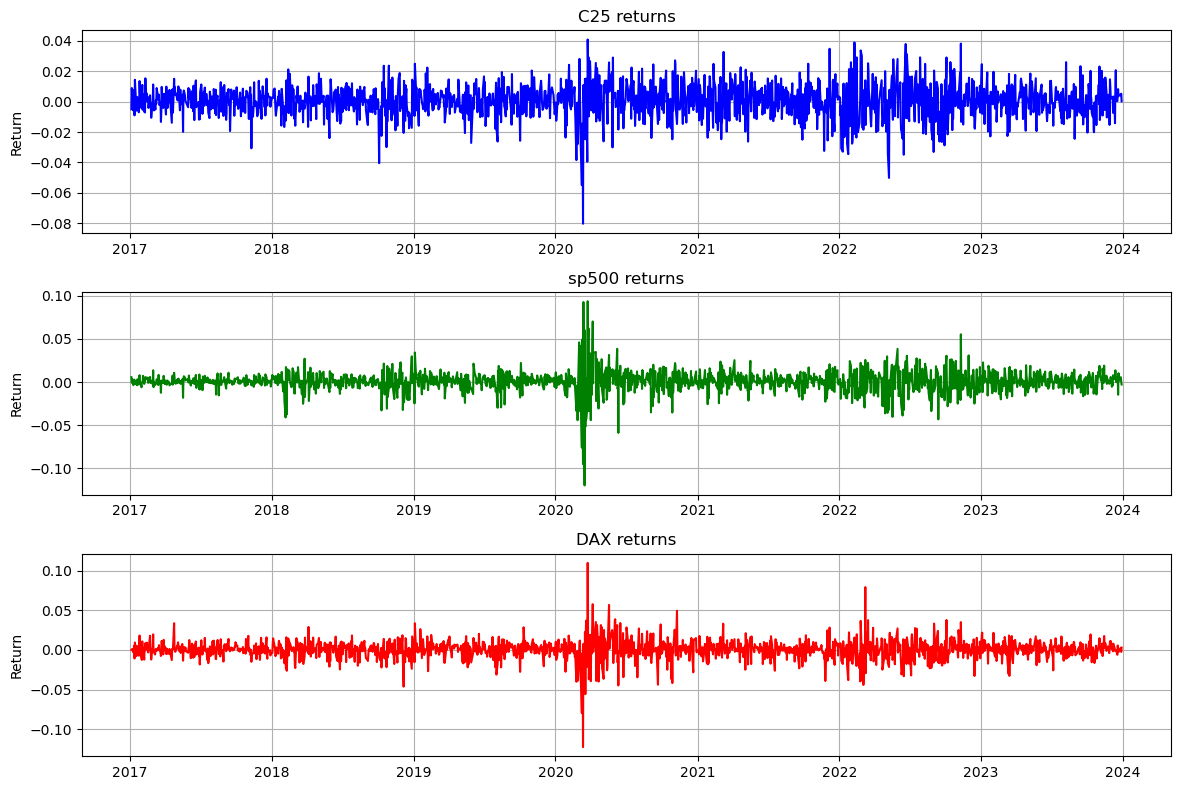

In [5]:
#Plotting the returns of each of C25, SP500 and DAX
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(df.index, returns['c25'], label='c25', color='b')
plt.title('C25 returns')
plt.ylabel('Return')
plt.grid(True)

# Plot for sp500
plt.subplot(3, 1, 2)
plt.plot(df.index, returns['sp500'], label='sp500', color='g')
plt.title('sp500 returns')
plt.ylabel('Return')
plt.grid(True)

# Plot for dax
plt.subplot(3, 1, 3)
plt.plot(df.index, returns['dax'], label='dax', color='r')
plt.title('DAX returns')
plt.ylabel('Return')
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
#Importing arch(GARCH) library and our class and creating an instance of this class
from arch import arch_model
from modelproject import GARCH
GARCH_Model = GARCH(returns)


In [7]:
#Estimating the parameters of our conditional model for the returns.
results = GARCH_Model.estimate()
parameter_estimates = GARCH_Model.get_parameter_estimates(results)
print(parameter_estimates)

             mu     omega  alpha[1]  beta[1]
c25    0.000532  0.000002      0.05     0.93
sp500  0.001075  0.000003      0.20     0.78
dax    0.000587  0.000003      0.10     0.88


**Using the model to find the conditional variances for each point in time:**

In [8]:
###---------------Calculating the conditional variances for each point in time for the succeeding period---------------###


#-----------C25-----------#

#Extracting the parameter-estimates from the above table
mu_c25 = parameter_estimates.loc['c25', 'mu']
omega_c25 = parameter_estimates.loc['c25', 'omega']
alpha_c25 = parameter_estimates.loc['c25', 'alpha[1]']
beta_c25 = parameter_estimates.loc['c25', 'beta[1]']

#Cleaning data and calculating residuals for each datapoint according to our model
returns_c25 = returns['c25'].dropna()
residuals_c25 = returns_c25 - mu_c25

#Initializing the list of conditional variances, where we assume that for the first point the investor assumes a conditional variance equal to the unconditional variance.
conditional_variances_c25 = [omega_c25 / (1 - alpha_c25 - beta_c25)]

for i in range(1, len(residuals_c25)):
    sigma_squared_c25 = omega_c25 + alpha_c25 * (residuals_c25.iloc[i-1] ** 2) + beta_c25 * conditional_variances_c25[i-1]
    conditional_variances_c25.append(sigma_squared_c25)

# Transforming conditional variances to standard deviations
conditional_std_devs_c25 = [variance ** 0.5 for variance in conditional_variances_c25]

#-----------sp500-----------#

#Extracting the parameter-estimates from the above table
mu_sp500 = parameter_estimates.loc['sp500', 'mu']
omega_sp500 = parameter_estimates.loc['sp500', 'omega']
alpha_sp500 = parameter_estimates.loc['sp500', 'alpha[1]']
beta_sp500 = parameter_estimates.loc['sp500', 'beta[1]']

#Cleaning data and calculating residuals for each datapoint according to our model
returns_sp500 = returns['sp500'].dropna()
residuals_sp500 = returns_sp500 - mu_sp500

#Initializing the list of conditional variances, where we assume that for the first point the investor assumes a conditional variance equal to the unconditional variance.
conditional_variances_sp500 = [omega_sp500 / (1 - alpha_sp500 - beta_sp500)]

for i in range(1, len(residuals_sp500)):
    sigma_squared_sp500 = omega_sp500 + alpha_sp500 * (residuals_sp500.iloc[i-1] ** 2) + beta_sp500 * conditional_variances_sp500[i-1]
    conditional_variances_sp500.append(sigma_squared_sp500)

# Transforming conditional variances to standard deviations
conditional_std_devs_sp500 = [variance ** 0.5 for variance in conditional_variances_sp500]

#-----------DAX-----------#

#Extracting the parameter-estimates from the above table
mu_dax = parameter_estimates.loc['dax', 'mu']
omega_dax = parameter_estimates.loc['dax', 'omega']
alpha_dax = parameter_estimates.loc['dax', 'alpha[1]']
beta_dax = parameter_estimates.loc['dax', 'beta[1]']

#Cleaning data and calculating residuals for each datapoint according to our model
returns_dax = returns['dax'].dropna()
residuals_dax = returns_dax - mu_dax

#Initializing the list of conditional variances, where we assume that for the first point the investor assumes a conditional variance equal to the unconditional variance.
conditional_variances_dax = [omega_dax / (1 - alpha_dax - beta_dax)]

for i in range(1, len(residuals_dax)):
    sigma_squared_dax = omega_dax + alpha_dax * (residuals_dax.iloc[i-1] ** 2) + beta_dax * conditional_variances_dax[i-1]
    conditional_variances_dax.append(sigma_squared_dax)

# Transforming conditional variances to standard deviations
conditional_std_devs_dax = [variance ** 0.5 for variance in conditional_variances_dax]


Now, we can plot these to get an overview of the modeled conditional volatility (the volatility expected by the investor each period towards the next period):

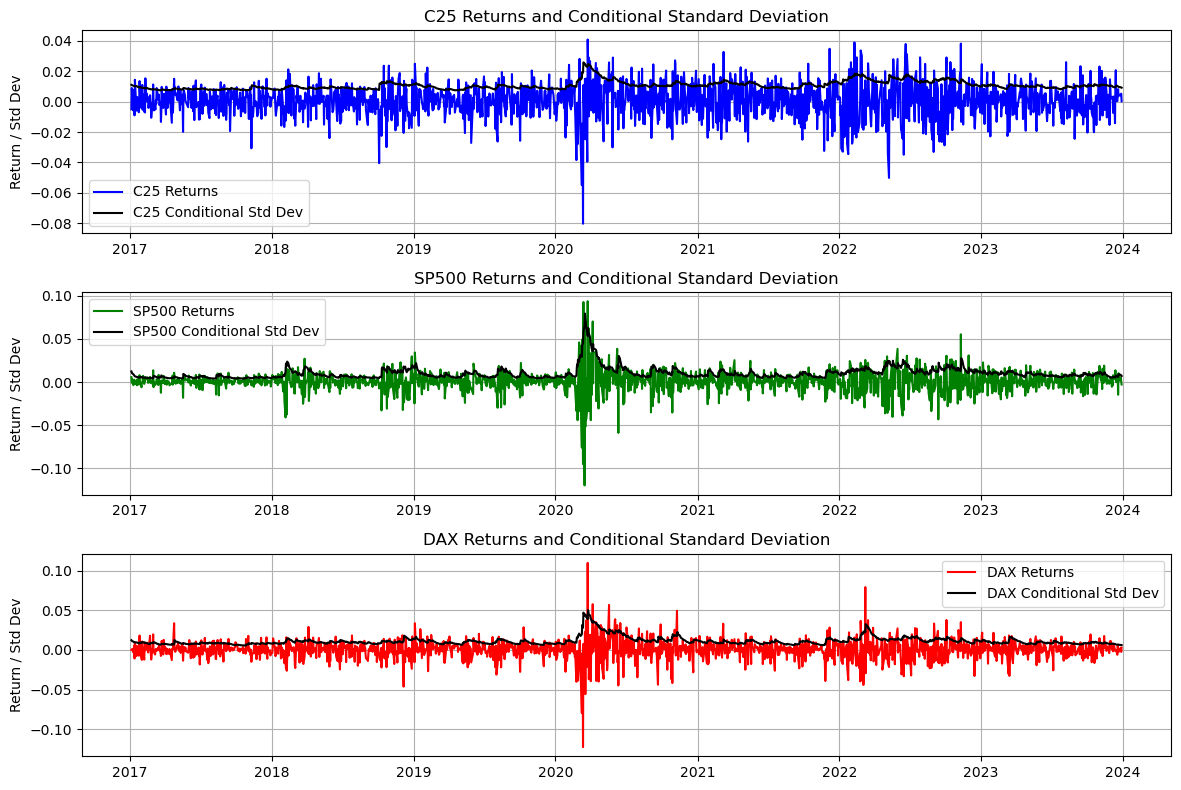

In [9]:
plt.figure(figsize=(12, 8))

# Plot for C25 returns and conditional standard deviations
plt.subplot(3, 1, 1)
plt.plot(returns_c25.index, returns_c25, label='C25 Returns', color='b')
plt.plot(returns_c25.index, conditional_std_devs_c25, label='C25 Conditional Std Dev', color='black')
plt.title('C25 Returns and Conditional Standard Deviation')
plt.ylabel('Return / Std Dev')
plt.legend()
plt.grid(True)

# Plot for SP500 returns and conditional standard deviations
plt.subplot(3, 1, 2)
plt.plot(returns_sp500.index, returns_sp500, label='SP500 Returns', color='g')
plt.plot(returns_sp500.index, conditional_std_devs_sp500, label='SP500 Conditional Std Dev', color='black')
plt.title('SP500 Returns and Conditional Standard Deviation')
plt.ylabel('Return / Std Dev')
plt.legend()
plt.grid(True)

# Plot for DAX returns and conditional standard deviations
plt.subplot(3, 1, 3)
plt.plot(returns_dax.index, returns_dax, label='DAX Returns', color='r')
plt.plot(returns_dax.index, conditional_std_devs_dax, label='DAX Conditional Std Dev', color='black')
plt.title('DAX Returns and Conditional Standard Deviation')
plt.ylabel('Return / Std Dev')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Now, as proposed in Bollerslev (1990), we will assume our indices to have a constant correlation, such that we can decompose the variance-covariance matrices for each point in time into:

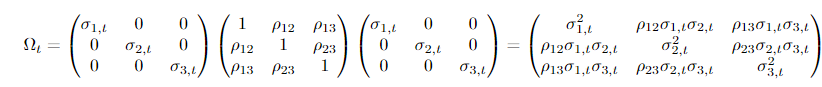


Using this, we can now create a list with the variance-covariance matrices for each point in time


In [11]:
#finding the constant correlation
correlation_matrix = returns.corr()

# Calculating variance-covariance matrices for each point in time
variance_covariance_matrices = []


#Looping through the elements of the conditional standard deviation lists to calculate the expected conditional variance-covariance for each point in time
for i in range(len(returns_c25)):
    std_devs = np.array([
        conditional_std_devs_c25[i],
        conditional_std_devs_sp500[i],
        conditional_std_devs_dax[i]
    ])
    D = np.diag(std_devs)
    variance_covariance_matrix = D @ correlation_matrix.values @ D
    variance_covariance_matrices.append(variance_covariance_matrix)

variance_covariance_matrices = np.array(variance_covariance_matrices)



            c25     sp500       dax
c25    1.000000  0.434310  0.648734
sp500  0.434310  1.000000  0.594704
dax    0.648734  0.594704  1.000000


Now that we have the expected variance-covariance matrix for each point in time, we can utlize the following method to find the efficient tangent portfolio using theory gained from the course Financial Decision Making (Peter Norman Sørensen). The method is constructing the matrix, $z_t$ according to

$$z_t=A^{-1}_t(\mu-r_f1)$$

where $A_t$ is the variance-covariance matrix and $\mu$ is a vector of the average/expected returns for the indices and $r_f1$ is a vector containing the assumed risk-free rate. Then, we can find the weights of the efficient tangent portfolio according to

$$x_{i,t}=\frac{z_{i,t}}{\sum_{i}z_{i,t}}$$

for $i=c25,sp500,dax $. For the theory underlying this method, one should consider taking the course :)

We will assume a constant risk-free rate of 3% annually.

In [12]:

risk_free_rate = 0.000117771086826757 #Corresponds to a risk free rate of 3% annually assuming 251 trading days a year

#Calculating the parameters that are constant over time
expected_return = parameter_estimates['mu'].values
excess_return_vector = np.matrix(expected_return - risk_free_rate).T #this is equal to \mu-r_f1

We can now loop over each variance-covariance matrix to find the optimal weights for each period:

In [14]:
efficient_tangent_portfolio_weights = []

# Looping over each variance-covariance matrix, inverting it, and then multiplying it by the excess_return_vector and lastly finding the weights
for variance_covariance_matrix in variance_covariance_matrices:
    z = np.linalg.inv(variance_covariance_matrix) @ excess_return_vector
    optimal_weights = (1/np.sum(z))*z
    efficient_tangent_portfolio_weights.append(optimal_weights)

efficient_tangent_portfolio_weights = np.array(efficient_tangent_portfolio_weights)



Now, by plotting these, we can see how the investor should reallocate the weights daily to optimze the portfolio:

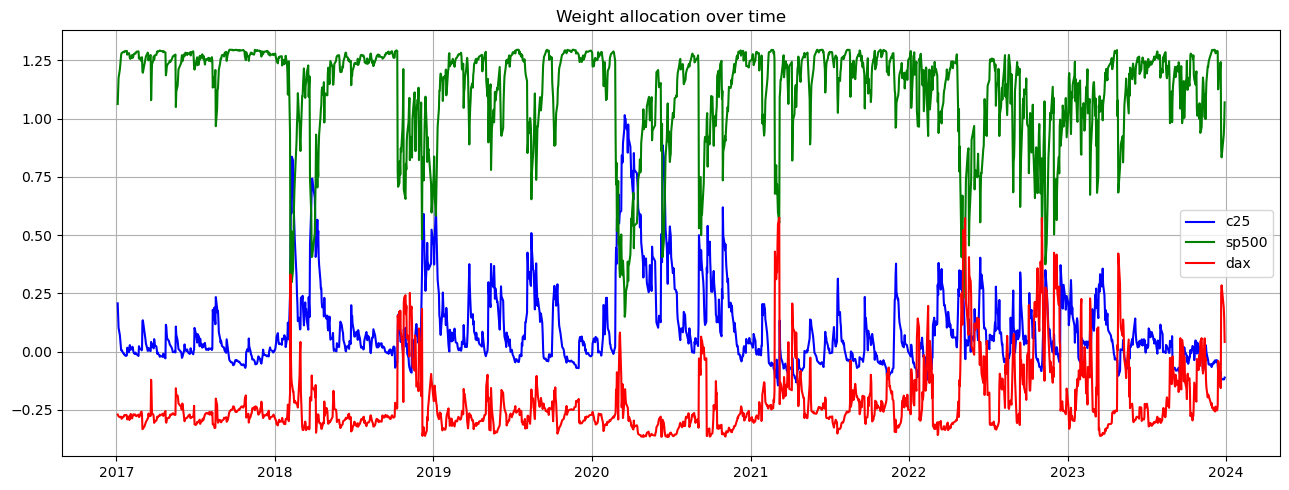

In [15]:
plt.figure(figsize=(13, 5))
plt.plot(returns_c25.index, efficient_tangent_portfolio_weights[:, 0], label='c25', color='b')
plt.plot(returns_sp500.index, efficient_tangent_portfolio_weights[:, 1], label='sp500', color='g')
plt.plot(returns_dax.index, efficient_tangent_portfolio_weights[:, 2], label='dax', color='r')
plt.title('Weight allocation over time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Now, that we have a list of the weights for the efficient tangent portfolio for each point in time, we can calculate - for each point in time - the portfolio's return. To do this, we utilize: 

$$port.return_t = return_tx_t$$

Where is $return_t$ is the vector of returns for the assets. Furthermore, as a measure of the performance of the portfolio we look at the Sharpe ratio given by 

$$Sharpe=\frac{port.return_{average}-r_f}{\bar{\sigma}}$$

where $\bar{\sigma}$ is the sample standard deviation / volatility of the portfolio returns

In [16]:
portfolio_returns = []
returns = returns.iloc[1:] # Adjusting so that the lists are the same length
risk_free_rate = 0.000117771086826757

for weight_vector, (_, row) in zip(efficient_tangent_portfolio_weights, returns.iterrows()):
    weight_vector = weight_vector.reshape(-1)
    portfolio_return = np.dot(weight_vector, row.values)
    portfolio_returns.append(portfolio_return)

# Calculate volatility (standard deviation) and average return
volatility = np.std(portfolio_returns)
avg_return = np.mean(portfolio_returns)

#Find the Sharpe-ratio of the portfolio
Sharpe_ratio = (avg_return-risk_free_rate)/volatility
print(Sharpe_ratio)

0.04229640525816774


From which we see that the Sharpe-ratio for the GARCH-optimal portfolio is around 4.7%. To see the benefit of GARCH-modelling and constant portfolio reallocation we can compare the portfolio with a benchmark that assumes volatility to be constant over time. This was what we did in our DataProject. Here, we showed - using the same data - that the efficient tangent portfolio had the weights given by:

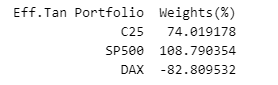

Thus we can now calculate the Sharpe-ratio of this:

In [17]:
benchmark_weights = np.array([0.74019178, 1.08790354, -0.82809532])

benchmark_portfolio_returns = []

for _, row in returns.iterrows():
    benchmark_return = np.dot(benchmark_weights, row.values)
    benchmark_portfolio_returns.append(benchmark_return)


benchmark_portfolio_returns = np.array(benchmark_portfolio_returns)

benchmark_avg_return = np.mean(benchmark_portfolio_returns)
benchmark_volatility = np.std(benchmark_portfolio_returns)

Sharpe_ratio_benchmark = (benchmark_avg_return-risk_free_rate)/benchmark_volatility
print(Sharpe_ratio_benchmark)


0.037497419018671777


And we notice that the Sharpe-ratio is lower, which suggests the efficacy of GARCH modelling and constant reallocation of weights. We can now compare the development of what investing 100kr in these portfolios would result in:

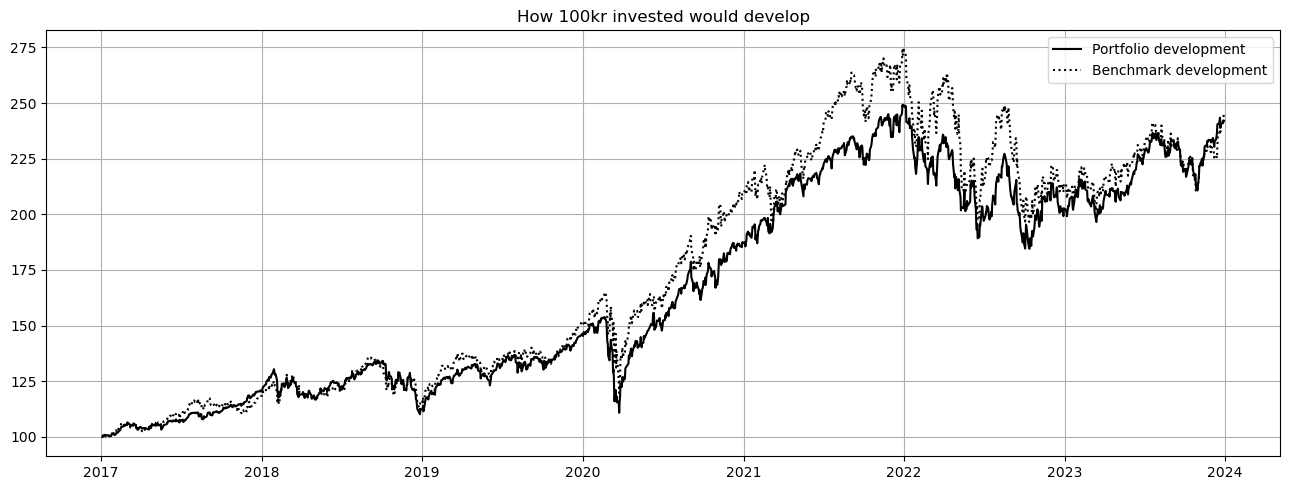

In [18]:
investment_index_portfolio = [100]  # Start with 100 kr
investment_index_benchmark = [100]  # Start with 100 kr


for portfolio_return in portfolio_returns:
    new_investment_value = investment_index_portfolio[-1] * (1 + portfolio_return)
    investment_index_portfolio.append(new_investment_value)


for benchmark_return in benchmark_portfolio_returns:
    new_investment_value_benchmark = investment_index_benchmark[-1] * (1 + benchmark_return)
    investment_index_benchmark.append(new_investment_value_benchmark)



plt.figure(figsize=(13, 5))
plt.plot(returns.index, investment_index_portfolio[:-1], label='Portfolio development', color='black')
plt.plot(returns.index, investment_index_benchmark[:-1], label='Benchmark development', color='black', linestyle=':')

plt.title('How 100kr invested would develop')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Interestingly, the graph shows that both the GARCH-optimized portfolio and the benchmark portfolio results (over time) in the same return on the 100kr. However, the Benchmark is more volatile and therefore, the GARCH-optimized portfolio generates a higher excess-return per unit of volatility since it is able to use knowledge regarding the clustering of volatility around uncertain periods.

The above shows one very interesting extension of the classic Capital Asset Pricing Model, as it additionally assumes that the investor can use his/her knowledge regarding volatility clustring to optimize the efficient tangent portfolio, which is commonly named the market portfolio. By doing this, we assume the 3 indices to be the only available assets to invest in and according to arbitrage absence, the return of this efficient tangent portfolio should reflect the general return on risky assets in general. The Capital Asset Pricing Model, however, does not answer the central question as towards how much to actually allocate towards risky assets and how much to allocate towards the risk-free rate. Therefore, we now engage another extension of the Capital Asset Pricing Model by further assuming that our representative investor seeks maximize his/her utility given the "budget constraint" given by:

$$R_{t+1}=w_t\cdot mkt_{t+1}+(1-w_t)\cdot r_f$$

We further assume that the investor gains utility from returns and disutility from volatility:

$$U_t=E[R_{t+1}]-\delta V[R_{t+1}]$$

Thus, we are interested in solving for the optimal weight $w_t$ that maximizes utility. To solve the problem we utilize scipy optimize and we note that we can calculate the variance at each point in time by
$$V_t=x_t^TA_tx_t$$
where $A_t$ is the variance co-variance matrix. Moreover, we notice that:

$$V[R_{t+1}]=V[w_t\cdot mkt_{t+1}+(1-w_t)\cdot r_f]=w_t^2\cdot V[mkt_{t+1}]+(1-w_t)^2\cdot V[r_f]=w_t^2\cdot V[mkt_{t+1}]+(1-w_t)^2\cdot 0=w_t^2\cdot V[mkt_{t+1}]$$





We initially assume that $\delta=8$


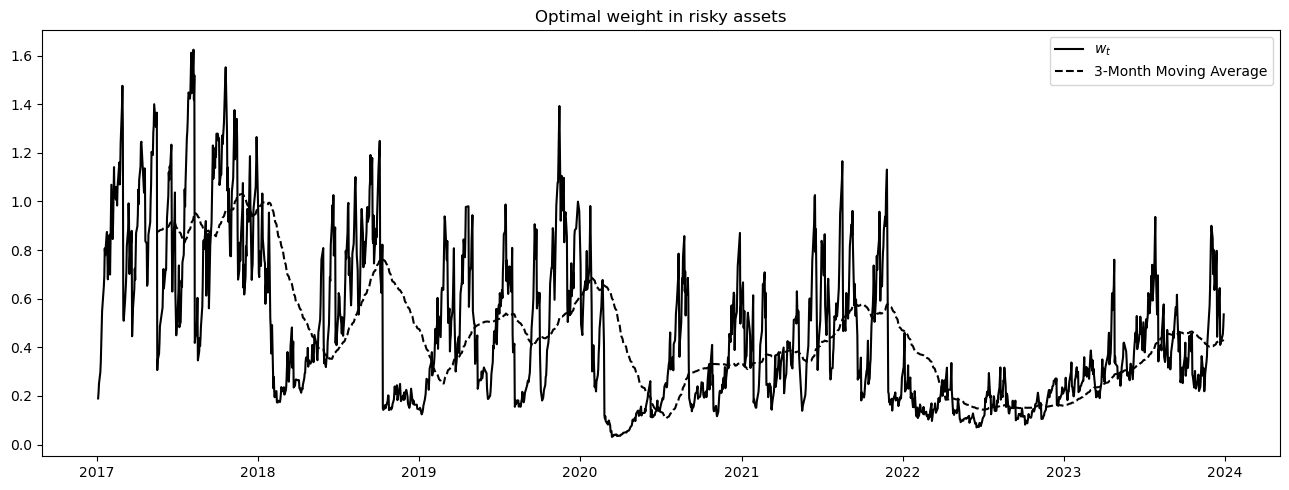

In [19]:
import scipy.optimize as opt

portfolio_variances = []

#Firstly, we make a list that contains the variances for each point in time for the portfolio of risky assets.
for weight_vector, covariance_matrix in zip(efficient_tangent_portfolio_weights, variance_covariance_matrices):
    # Calculate the variance
    variance = np.transpose(weight_vector).dot(covariance_matrix).dot(weight_vector)
    portfolio_variances.append(variance.item())

delta = 8


optimal_weights_to_allocate_in_risky_assets = []


# Define the utility function
def utility_function(w, R, V, rf, delta):
    final_portfolio_return = w * R + (1 - w) * rf
    final_portfolio_variance = w**2 * V 
    utility = final_portfolio_return - delta * final_portfolio_variance
    return -utility  # Negative because we will minimize this function


# Loop through each point in time
for Variance in portfolio_variances:

    #and minimize the utility
    result = opt.minimize_scalar(utility_function, bounds=(-10, 10), args=(avg_return, Variance, risk_free_rate, delta), method='bounded')
    
    optimal_weight = result.x
    
    optimal_weights_to_allocate_in_risky_assets.append(optimal_weight)
    
# Convert the optimal weights to a pandas Series to calculate the moving average
optimal_weights_series = pd.Series(optimal_weights_to_allocate_in_risky_assets, index=returns.index)

# Calculate the 3-month moving average
moving_average_3_months = optimal_weights_series.rolling(window=90).mean()





plt.figure(figsize=(13, 5))
plt.plot(returns.index, optimal_weights_to_allocate_in_risky_assets, label='$w_t$', color='black')
plt.plot(returns.index, moving_average_3_months, label='3-Month Moving Average', color='black', linestyle='--')

plt.title('Optimal weight in risky assets')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()




From this, it is evident, that the optimal weight to put on risky assets is quite volatile and dictates the investor to reallocate very frequently. We notice, that for the whole period, the investor should allocate a positive weight on risky assets and for (almost) the whole period he/she should not utilize shorting any of the two (when looking at the moving average). The picture, however becomes another when adjusting the parameter that expresses the risk aversion, $\delta$. Below we compare $\delta=8$ to $\delta=4$ (less risk aversion) and $\delta=16$ (higher risk aversion):

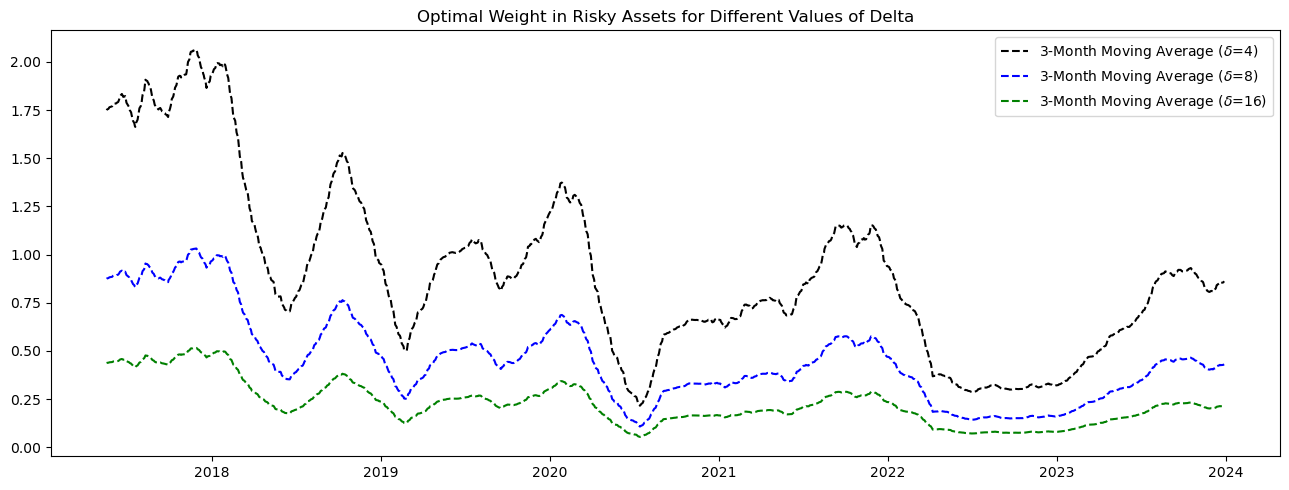

In [20]:

deltas = [4, 8, 16]


optimal_weights_dict = {}
moving_averages_dict = {}

for delta in deltas:
    optimal_weights_to_allocate_in_risky_assets = []

    # Loop through each point in time and minimize the utility
    for Variance in portfolio_variances:
        result = opt.minimize_scalar(utility_function, bounds=(-10, 10), args=(avg_return, Variance, risk_free_rate, delta), method='bounded')
        optimal_weight = result.x
        optimal_weights_to_allocate_in_risky_assets.append(optimal_weight)

    # Convert the optimal weights to a pandas Series to calculate the moving average
    optimal_weights_series = pd.Series(optimal_weights_to_allocate_in_risky_assets, index=returns.index)

    # Calculate the 3-month moving average
    moving_average_3_months = optimal_weights_series.rolling(window=90).mean()

    # Store the results in the dictionaries
    moving_averages_dict[delta] = moving_average_3_months

# Plot the results outside the loop
plt.figure(figsize=(13, 5))
colors = ['black', 'blue', 'green']
for delta, color in zip(deltas, colors):
    plt.plot(returns.index, moving_averages_dict[delta], label=f'3-Month Moving Average ($\delta$={delta})', color=color, linestyle='--')
plt.title('Optimal Weight in Risky Assets for Different Values of Delta')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()